In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
from ipywidgets import interact

Populating the interactive namespace from numpy and matplotlib


# Predator prey with logistic growth and stochastic disease outbreaks

This is the form of the original predator-prey model with logistic growth, which describe what happens when there is no disease causing death among predators and prey

$$
\begin{align*}
 \dot{x} &= ax\left(1 - \frac{x}{K}\right) - bxy,\quad x(0) = x_0\\
 \dot{y} &= cxy - dy,\quad y(0) = y_0
\end{align*}
$$

The transition diagram for an equivalent birth-death process is

$$
\begin{gather*}
N-1
{{ \atop\longrightarrow}\atop{\longleftarrow\atop \epsilon b NM + \epsilon N^2 a/K}} 
N
 {{a N \atop\longrightarrow}\atop{\longleftarrow\atop}} 
N+1 \\
M - 1
{{\atop\longrightarrow}\atop{\longleftarrow\atop  dM}} 
M
{{\epsilon c NM \atop\longrightarrow}\atop{\longleftarrow\atop }} 
M+1
\end{gather*}
$$

When disease causes deaths among the two populations, we have

$$
\begin{align*}
 \dot{x} &= ax\left(1 - \frac{x}{K}\right) - bxy - sx,\quad x(0) = x_0\\
 \dot{y} &= cxy - dy - wy,\quad y(0) = y_0
\end{align*}
$$

Where ***s*** is the lethality of the disease on the prey population, and ***w*** is the lethality of the disease on the predator population. The transition rate diagram for when the disease is active is the following

$$
\begin{gather*}
N-1
{{ \atop\longrightarrow}\atop{\longleftarrow\atop \epsilon b NM + \epsilon N^2 a/K+ sN}} 
N
 {{a N \atop\longrightarrow}\atop{\longleftarrow\atop}} 
N+1 \\
M - 1
{{\atop\longrightarrow}\atop{\longleftarrow\atop  dM+ wM}} 
M
{{\epsilon c NM \atop\longrightarrow}\atop{\longleftarrow\atop }} 
M+1
\end{gather*}
$$

The variables ***s*** and ***w*** become part of the overall rate based on a stochastic process below, where a random variable is generated and, depending on its value, s and w could either be activated and become part of the overall rate or turn off and be removed from the actual rate.

\begin{gather*}
S=0
{{αn^2 \atop\longrightarrow}\atop{\longleftarrow\atop β/n^2}} 
S=1
\end{gather*}

### Constants

We will keep the following variables constant throughout the notebook. We will only be modifying `s` and `w` to set the lethality of disease on the two populations and examine when extinction takes place.


In [2]:
epsilon = 0.05
a = 2.4 # intrinsic growth rate for prey population
b = 0.5 # prey death rate
c = 1.6 # intrinsic growth rate for predator population
d = 1.8 # predator death rate
K = 4 # carrying capacity
x0 = 4. # starting prey population
y0 = 4. # starting predator population
n0 = int(x0/epsilon)
m0 = int(y0/epsilon)
Nsteps = 100000 # we will run for Nsteps
alpha_s = 0.0001 # transition rate from disease off to disease on
beta_s = 4 # transition rate from disease on to disease off

### Stochastic predator-prey with disease function

We expanded on `stochastic_pp` to calculate the combined rate to include the effects due to diseases based on the state of the disease and expanding the `probability_vector` to include disease on/off events.

In [3]:
def stochastic_pp_with_disease(a, b, c, d, s, w, alpha_s, beta_s, epsilon, n0, m0, Nsteps):
    N = zeros(Nsteps)
    N[0] = n0
    M = zeros(Nsteps)
    M[0] = m0
    T = zeros(Nsteps)
    T[0] = 0
    S = zeros(Nsteps)
    S[0] = 0
    for j in arange(1, Nsteps):
        n = N[j-1]
        m = M[j-1]
        #### There are 5 'arrows' leaving a given state: N-birth, N-death, M-birth, M-death, Disease on/off
        if S[j-1]==1:
            combined_rate = a*n + epsilon*b*n*m + epsilon*n**2*a/K + epsilon*c*n*m + d*m + s*n + w*m + beta_s/n**2 # plague on
        else:
            combined_rate = a*n + epsilon*b*n*m + epsilon*n**2*a/K + epsilon*c*n*m + d*m + alpha_s*n**2 # plague off
        u = rand(1)[0]
        tau = -log(u)/combined_rate
        T[j] = T[j-1] + tau # update time array with new time value
        ## now we make a random variable to decide if birth, death or disease switch occurs
        ## the order in the vector is N-birth, N-death, M-birth, M-death, Disease on/off
        if S[j-1] == 1:
            probability_vector = array([a*n, epsilon*b*n*m + s*n + epsilon*n**2*a/K, epsilon*c*n*m, d*m + w*m, beta_s/n**2 ])/combined_rate
        else:
            probability_vector = array([a*n, epsilon*b*n*m + epsilon*n**2*a/K, epsilon*c*n*m, d*m, alpha_s*n**2])/combined_rate
        cummulative_probability_vector = cumsum(probability_vector)
        u2 = rand(1)[0]
        if u2 < cummulative_probability_vector[0]:
            N[j] = N[j-1] + 1
            M[j] = M[j-1]
            S[j] = S[j-1]
        elif u2 < cummulative_probability_vector[1]:
            N[j] = N[j-1] - 1
            M[j] = M[j-1]
            S[j] = S[j-1]
        elif u2 < cummulative_probability_vector[2]:
            N[j] = N[j-1]
            M[j] = M[j-1] + 1
            S[j] = S[j-1]
        elif u2 < cummulative_probability_vector[3]:
            N[j] = N[j-1]
            M[j] = M[j-1] - 1
            S[j] = S[j-1]
        else:
            N[j] = N[j-1]
            M[j] = M[j-1]
            if S[j-1]==1:
                S[j] = 0
            else:
                S[j] = 1

        ### check for extinction for both predator and prey
        if N[j] == 0 or M[j] == 0:
            return T[:j+1], N[:j+1], M[:j+1], S[:j+1] # return the solution so far
    return T, N, M, S

### Phase plane

We will use the function below to plot the phase plane.

In [4]:

def phase_plane(a, b, c, d, s, w, T, N , M, S):
    figure(1, [10, 7])
    plot(epsilon*N, epsilon*M, '-o')
    ## fixed points
    xhat = d/c
    yhat = a/b*(1 - d/c/K)
    plot(xhat, yhat, 'ok')
    plot(0, 0, 'ok')
    plot(K, 0, 'ok')

    ###### for vector field and phase plane
    ## x-nullcline
    x = linspace(0, 8, 200)
    plot(0*x, x, 'b')
    plot(x, a/b*(1 - x/K), 'b')
    ## y-nullcline
    x = d/c*ones(200)
    y = linspace(-0.1, 8, 200)
    plot(y, 0*y, 'r')
    plot(x, y, 'r')
    ## vector field
    X, Y = meshgrid(linspace(0, 5, 20), linspace(0, 8, 20))
    U = a*X*(1 - X/K) - b*X*Y - s*X
    V = c*X*Y - d*Y - w*Y
    streamplot(X, Y, U, V, color='0.75')

    xlim(-0.01, 5)
    ylim(-0.1, 8)
    xlabel('x (prey)', fontsize=24)
    ylabel('y (predator)', fontsize=24);

### Population over time

We will use the function below to see how population evolved over time. There are indicators for the points in time the disease became active, as well as indicators for when the disease became inactive.

In [5]:
def pp_over_t(s, w, T, N , M, S):
    figure(2, [10, 7])
    plot(T, N, '-.', color='blue')
    plot(T, M, '-.', color='orange')

    # Mark the points where disease turned on/off, if disease is active
    if s > 0.0 or w > 0.0:
        for i in arange(1, T.size):
            if S[i-1]==0 and S[i] == 1:
                x = linspace(0, 100, 25)
                plot((0*x+T[i]), x, '+', color='red')
            elif S[i-1]==1 and S[i] == 0:
                x = linspace(0, 100, 25)
                plot((0*x+T[i]), x, 'x', color ='green')
            else:
                continue
        legend(['Prey','Predator', 'Disease on', 'Disease off'], loc='upper right')
    else:
        legend(['Prey','Predator'])
        
    xlabel('t', fontsize=24)
    ylabel('x,y', fontsize=24)

### Extinction event statistics

The function below will use the results of the first run used to generate the charts and perform 10 more runs and tally how often extinction events happen and which species goes extinct

In [6]:
### Run multiple times to check how many times extinction happens:

def get_extinction_stats(a, b, c, d, s, w, alpha_s, beta_s, epsilon, n0, m0, Nsteps, T,N,M,S):
    tempT = T
    tempN = N
    tempM = M
    tempS = S

    numExtinctPrey = 0
    numExtinctPredator = 0
    numNoExtinct = 0

    print("Performing 10 runs to determine extinction...")

    for i in range(10):
        if tempN[-1] == 0:
            numExtinctPrey+=1
        elif tempM[-1] == 0:
            numExtinctPredator+=1
        else:
            numNoExtinct+=1
    
        tempT, tempN, tempM, tempS = stochastic_pp_with_disease(a, b, c, d, s, w, alpha_s, beta_s, epsilon, n0, m0, Nsteps)

    print("Number of times prey went extinct: " + str(numExtinctPrey))
    print("Number of times predator went extinct: " + str(numExtinctPredator))
    print("Number of times no extinction happened: " + str(numNoExtinct))



# Disease mainly affects prey

In this run, we set s = 0.2 and w = 0.1

Performing 10 runs to determine extinction...
Number of times prey went extinct: 3
Number of times predator went extinct: 5
Number of times no extinction happened: 2


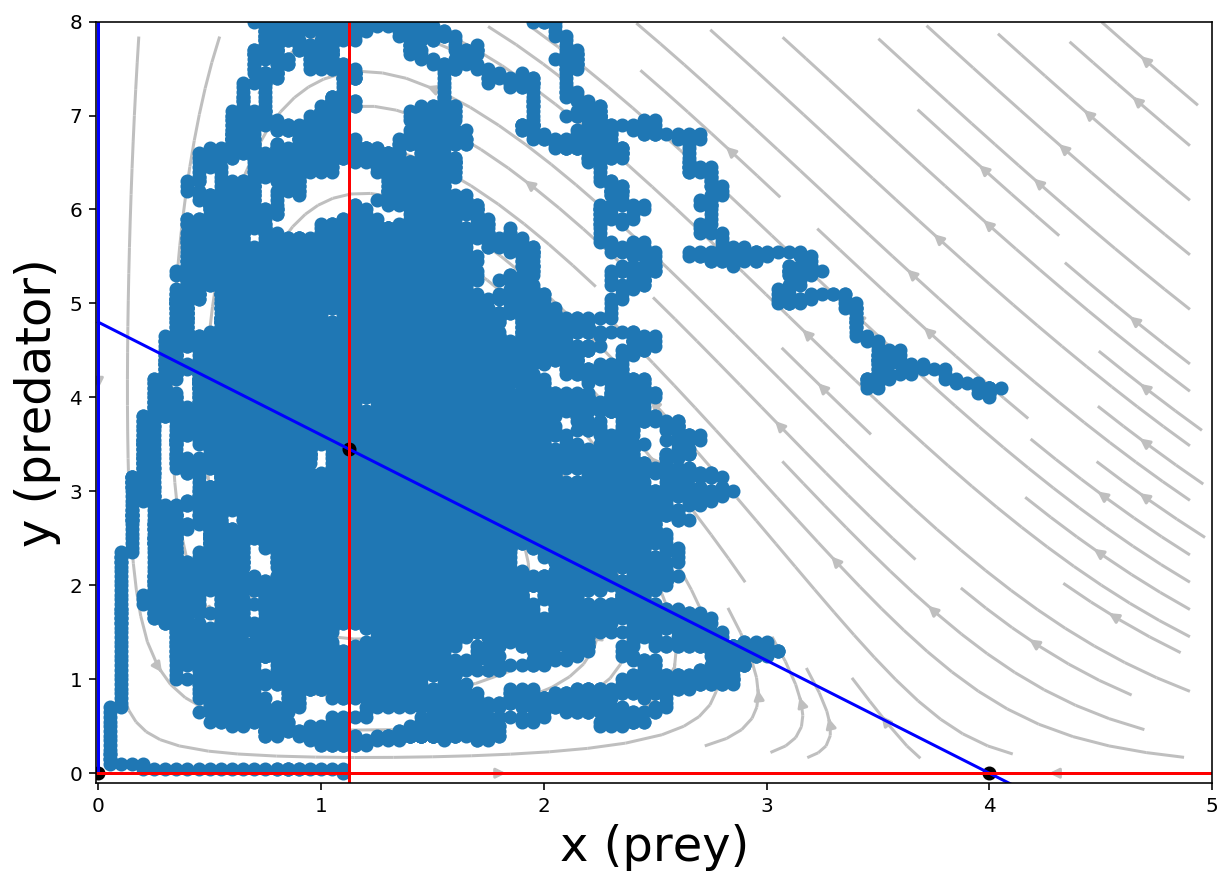

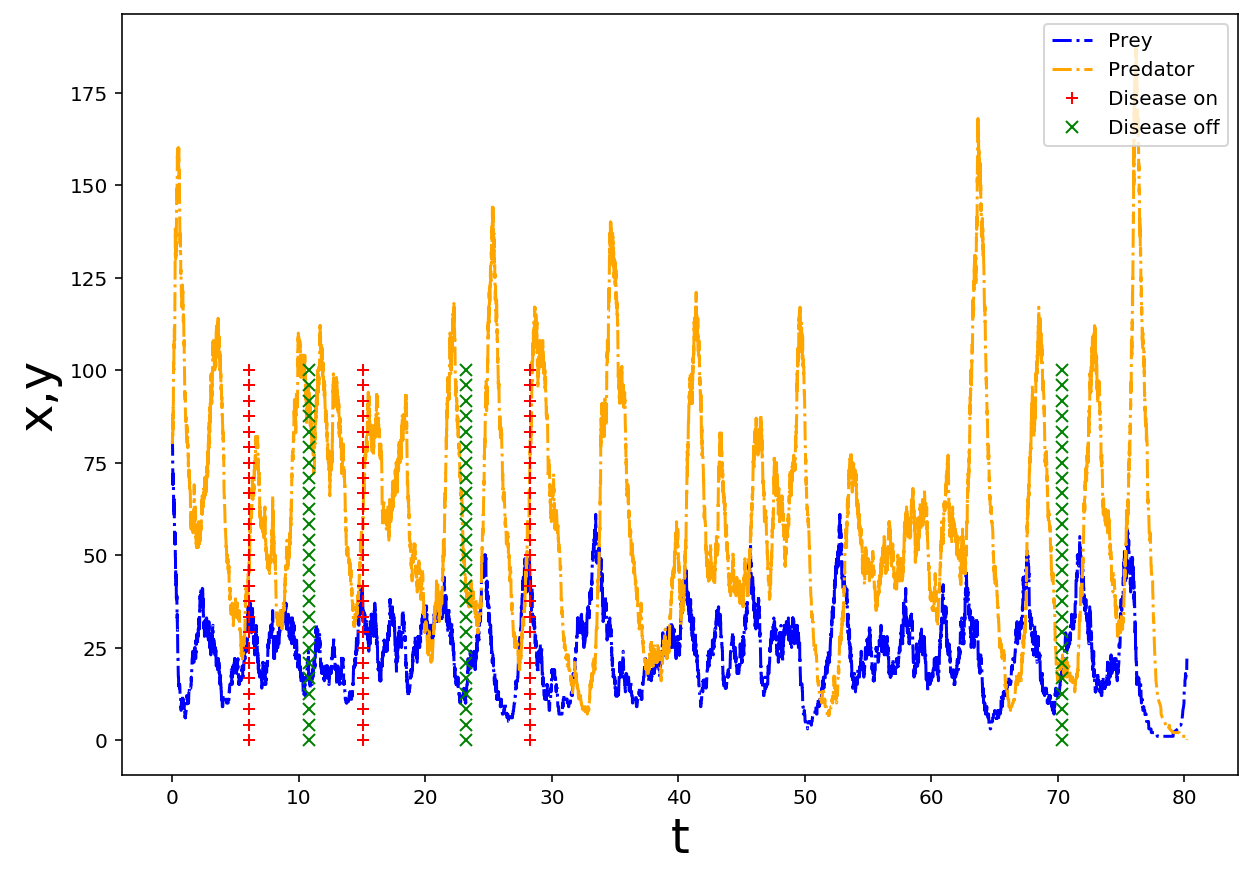

In [7]:
s = 0.2 # death due to disease for prey
w = 0.1 # death due to disease for predator
T, N, M, S = stochastic_pp_with_disease(a, b, c, d, s, w, alpha_s, beta_s, epsilon, n0, m0, Nsteps)
phase_plane(a, b, c, d, s, w, T, N , M, S)
pp_over_t(s,w,T,N,M,S)
get_extinction_stats(a, b, c, d, s, w, alpha_s, beta_s, epsilon, n0, m0, Nsteps, T, N, M, S)

# Disease mainly affects predators

In this run, we set s = 0.1 and w = 0.2

Performing 10 runs to determine extinction...
Number of times prey went extinct: 3
Number of times predator went extinct: 3
Number of times no extinction happened: 4


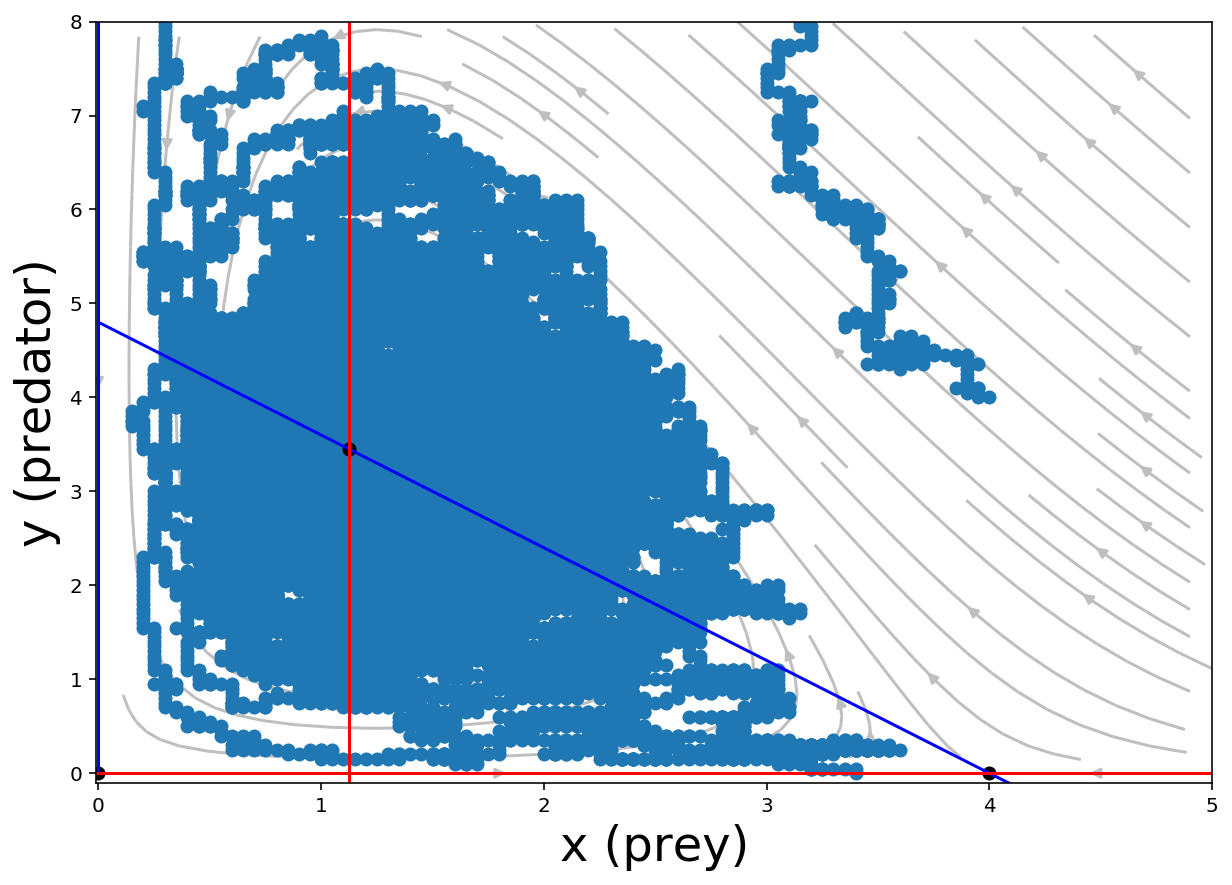

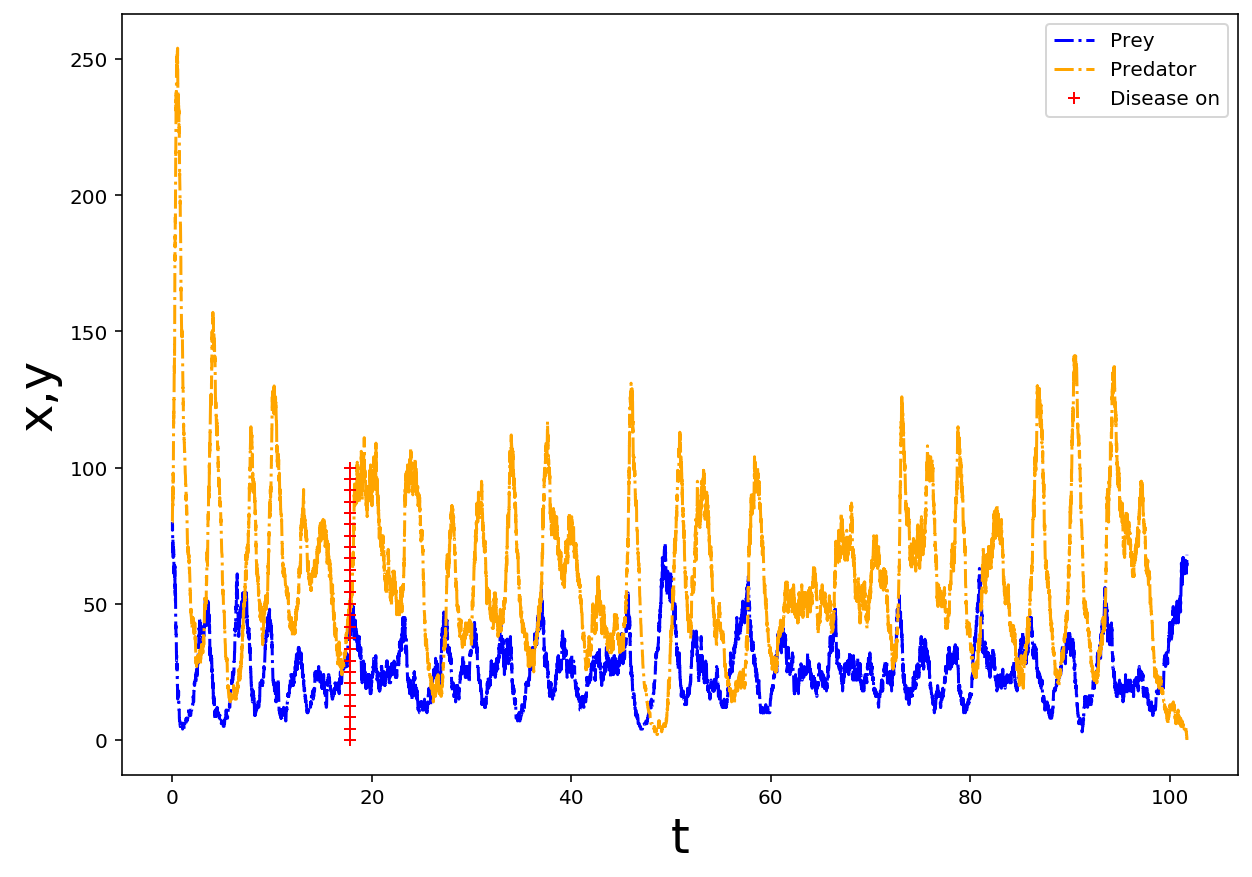

In [8]:
s = 0.1 # death due to disease for prey
w = 0.2 # death due to disease for predator
T, N, M, S = stochastic_pp_with_disease(a, b, c, d, s, w, alpha_s, beta_s, epsilon, n0, m0, Nsteps)
phase_plane(a, b, c, d, s, w, T, N , M, S)
pp_over_t(s,w,T,N,M,S)
get_extinction_stats(a, b, c, d, s, w, alpha_s, beta_s, epsilon, n0, m0, Nsteps, T, N, M, S)

# Disease affects both predators and prey

In this run, we set s = w = 0.15

Performing 10 runs to determine extinction...
Number of times prey went extinct: 2
Number of times predator went extinct: 4
Number of times no extinction happened: 4


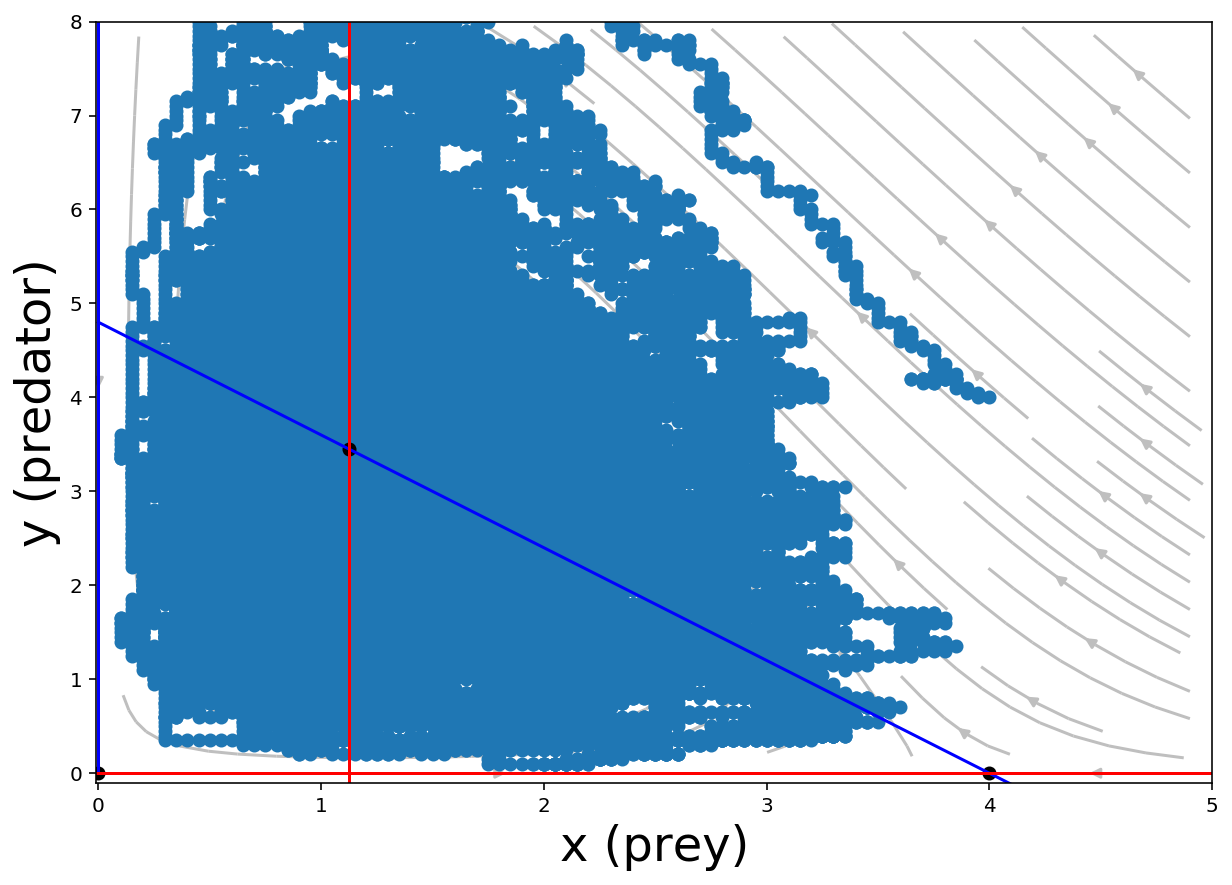

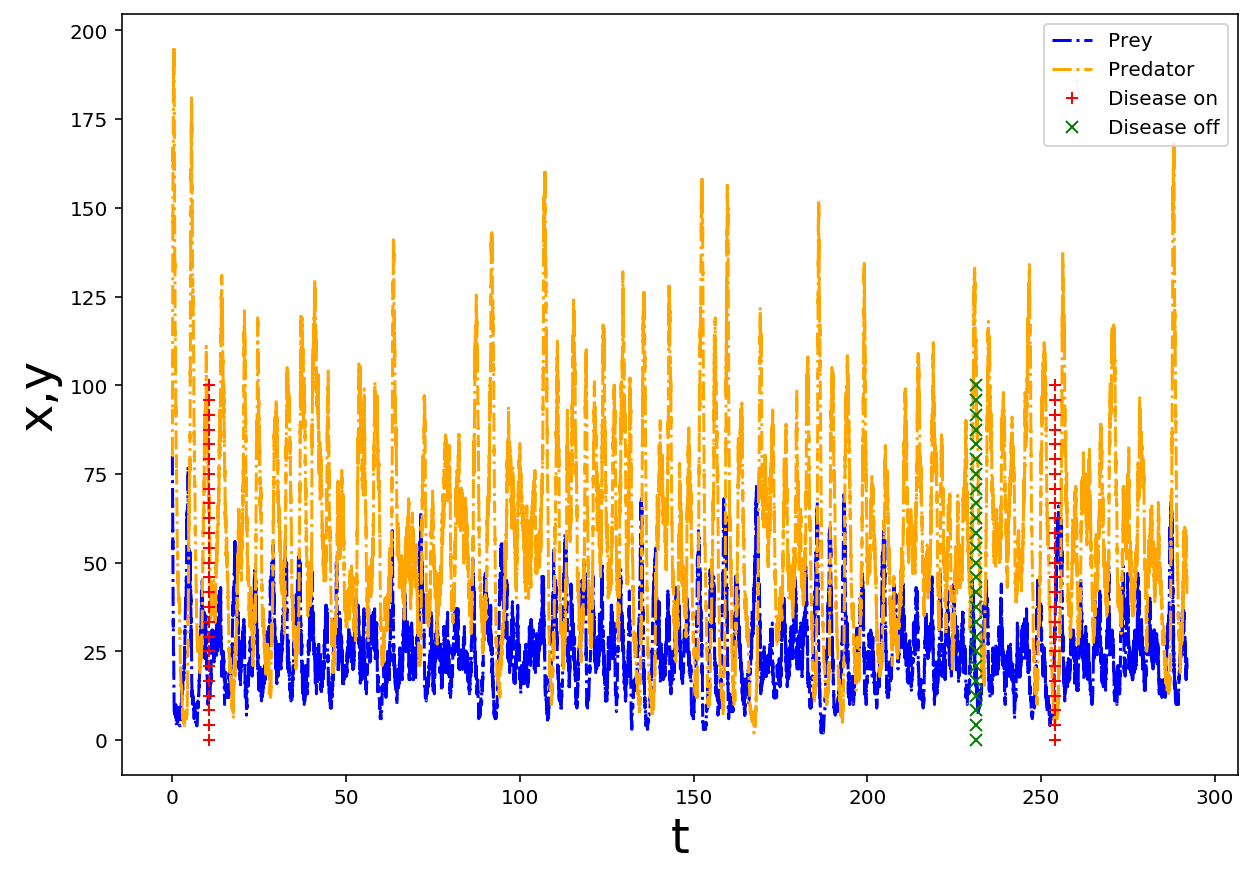

In [9]:
s = 0.15 # death due to disease for prey
w = 0.15 # death due to disease for predator
T, N, M, S = stochastic_pp_with_disease(a, b, c, d, s, w, alpha_s, beta_s, epsilon, n0, m0, Nsteps)
phase_plane(a, b, c, d, s, w, T, N , M, S)
pp_over_t(s,w,T,N,M,S)
get_extinction_stats(a, b, c, d, s, w, alpha_s, beta_s, epsilon, n0, m0, Nsteps, T, N, M, S)

# Control: no deaths resulting from diseases

Here, we set s = w = 0

Performing 10 runs to determine extinction...
Number of times prey went extinct: 6
Number of times predator went extinct: 2
Number of times no extinction happened: 2


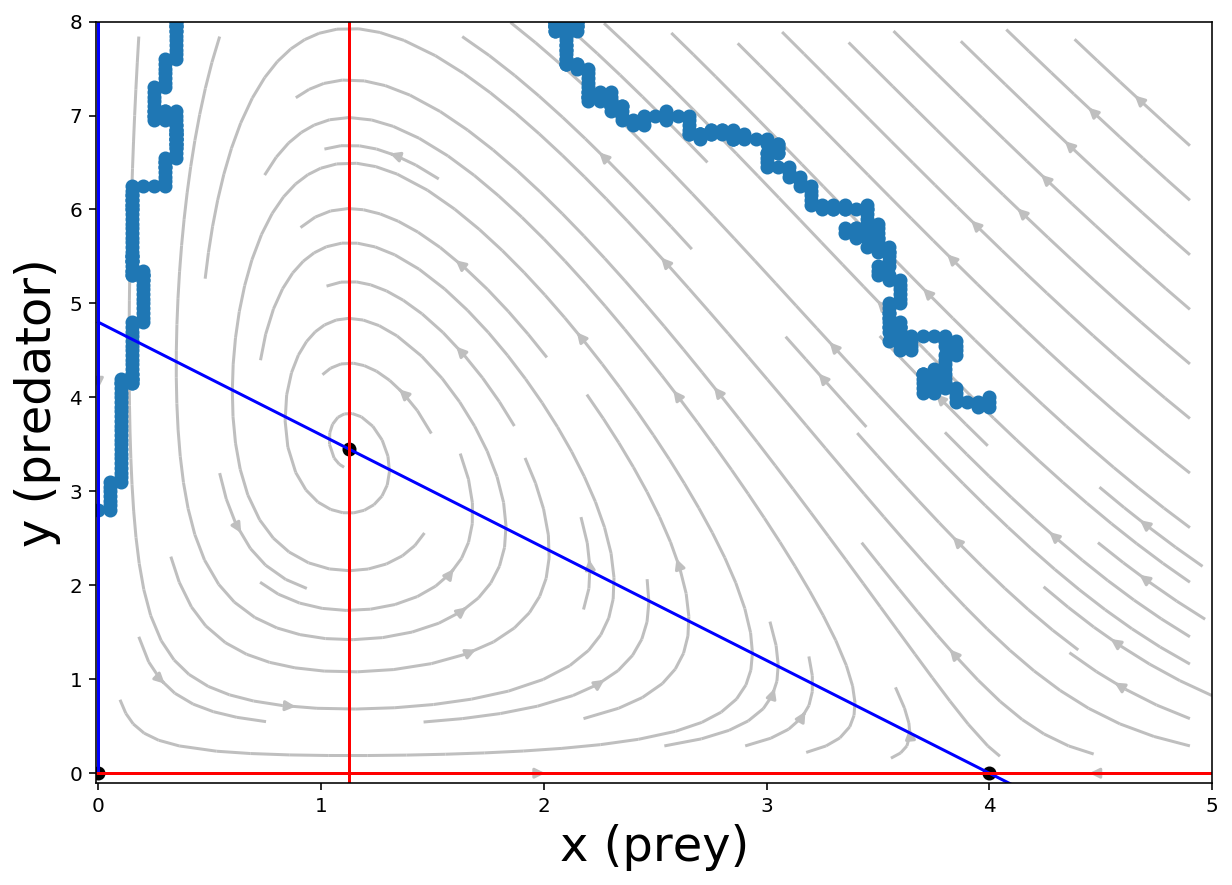

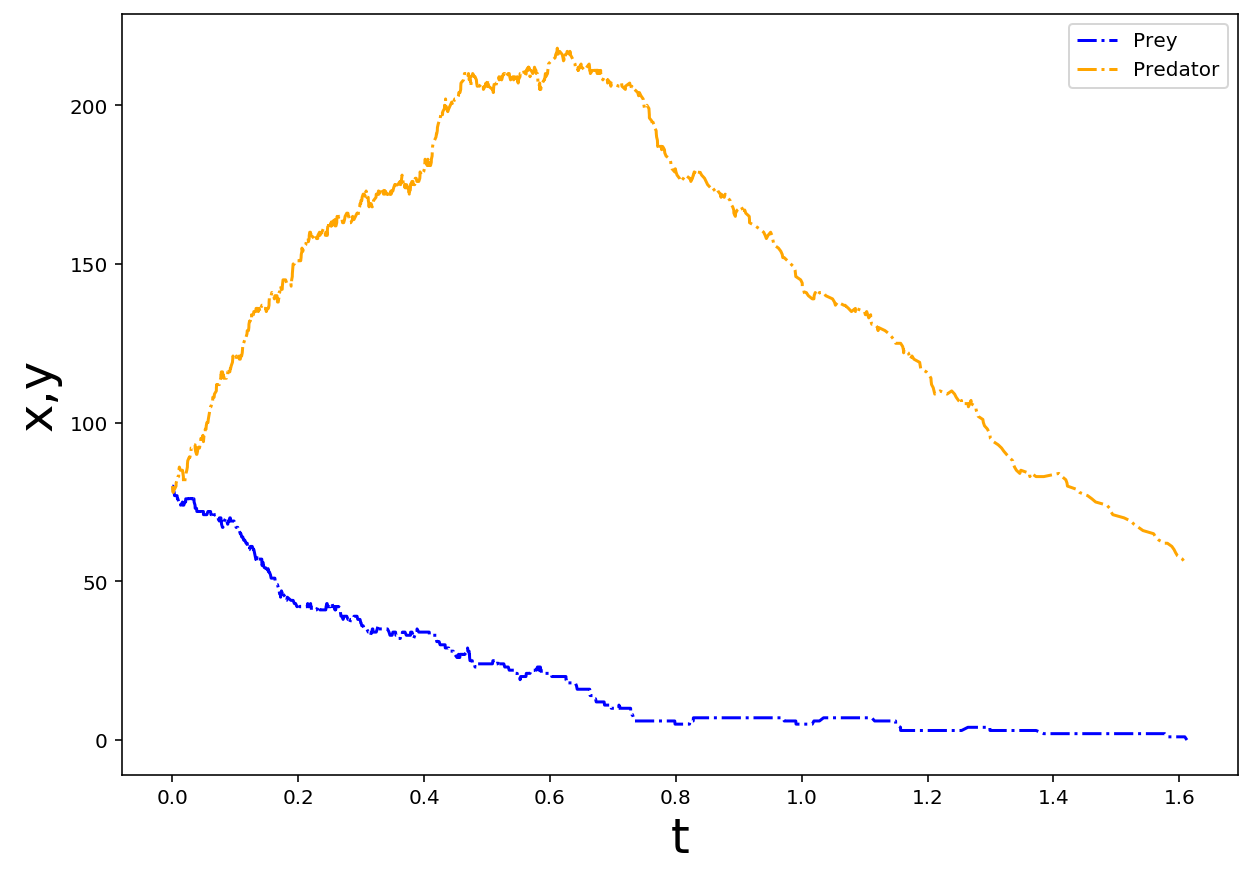

In [10]:
s = 0 # death due to disease for prey
w = 0 # death due to disease for predator
T, N, M, S = stochastic_pp_with_disease(a, b, c, d, s, w, alpha_s, beta_s, epsilon, n0, m0, Nsteps)
phase_plane(a, b, c, d, s, w, T, N , M, S)
pp_over_t(s,w,T,N,M,S)
get_extinction_stats(a, b, c, d, s, w, alpha_s, beta_s, epsilon, n0, m0, Nsteps, T, N, M, S)